### Notebook for the batch correction of cardiac immune cells using `scvi-tools`. 

- Created by Dr. Carlos Talavera-López Ph.D - Institute of AI for Health, Helmholtz Zentrum Munchen.
- 210701

- This notebook is designed to run on Google Colab. For more information about Colab, please refer to [this](https://towardsdatascience.com/getting-started-with-google-colab-f2fff97f594c) post.

- You will also need to access the data on Gdrive. See the session requisits on how to do this. 

### Load required modules

- Set up the environment to install `scvi-tools`

In [1]:
import sys

branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

     |████████████████████████████████| 204kB 5.2MB/s 
     |████████████████████████████████| 245kB 43.6MB/s 
     |████████████████████████████████| 634kB 37.7MB/s 
     |████████████████████████████████| 215kB 53.5MB/s 
     |████████████████████████████████| 81kB 11.7MB/s 
     |████████████████████████████████| 819kB 44.2MB/s 
     |████████████████████████████████| 133kB 60.5MB/s 
     |████████████████████████████████| 11.3MB 23.7MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 8.8MB 20.9MB/s 
     |████████████████████████████████| 3.2MB 28.0MB/s 
     |████████████████████████████████| 1.4MB 58.5MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
     |████████████████████████████████| 10.6MB 63.6MB/s 
     |████████████████████████████████| 829kB 50.5MB/s 
     |████████████████████████████████| 235kB 54.6MB/s 
     |████████████████████████████████| 645kB 53.1MB/s 
     |████████████████████████████████| 122kB 70.6MB

- Load packages 

In [2]:
import scvi
import numpy as np
import pandas as pd
import scanpy as sc

import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [14]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg')

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.8.0
sinfo       0.3.4
-----
2f7ece400a652629565c523b34ee61b04afa385c    NA
PIL                                         7.1.2
absl                                        NA
astor                                       0.8.1
astunparse                                  1.6.3
attr                                        21.2.0
bottleneck                                  1.3.2
cached_property                             1.5.2
certifi                                     2021.05.30

### Read in dataset 

- For this we will link Colab to GDrive. This is easily done with the command below. 
- This will be the basis of your GDrive directory. 
- Once you run the command, it will produce a link to authenticate your GDrive account. Click on it, copy the code it will give you and paste it back into the little box.  

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
heart_immune = sc.read_h5ad('/content/gdrive/My Drive/INBOX/lisbon_2021/raw_data/hca_heart_immune_raw.h5ad')
heart_immune

AnnData object with n_obs × n_vars = 40868 × 33538
    obs: 'NRP', 'age_group', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'type', 'version', 'scNym', 'scNym_confidence'
    uns: 'cell_states_colors', 'scNym_colors', 'scNym_probabilities'
    obsm: 'X_pca', 'X_scnym', 'X_umap'

### Data processing 

- NOTE: `scvi-tools` expects **raw counts** as input. Make sure you've got **raw counts** in `adata.X`.

- Select a label from the `adata` object that will serve to guide the batch correction. 
- In case there are more than one labels, create a combined label. 
- To reproduce the workd one by Litvinuoká et al 2020, we will create a combined label to correct for `cell_source` and `donor`.  

In [5]:
heart_immune.obs['combined'] = [str(heart_immune.obs.loc[i,'donor']) + str(heart_immune.obs.loc[i,'cell_source']) for i in heart_immune.obs_names]
heart_immune

AnnData object with n_obs × n_vars = 40868 × 33538
    obs: 'NRP', 'age_group', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'type', 'version', 'scNym', 'scNym_confidence', 'combined'
    uns: 'cell_states_colors', 'scNym_colors', 'scNym_probabilities'
    obsm: 'X_pca', 'X_scnym', 'X_umap'

- Transform data and select HVGs

In [6]:
adata_raw = heart_immune.copy()

In [7]:
heart_immune.layers["counts"] = heart_immune.X.copy()
sc.pp.normalize_total(heart_immune, target_sum = 1e6)
sc.pp.log1p(heart_immune)
heart_immune.raw = heart_immune  # keep full dimension safe

In [8]:
sc.pp.highly_variable_genes(
    heart_immune,
    flavor="seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "combined",
    subset = True,
    span = 1
)
heart_immune

AnnData object with n_obs × n_vars = 40868 × 7000
    obs: 'NRP', 'age_group', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'type', 'version', 'scNym', 'scNym_confidence', 'combined'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'cell_states_colors', 'scNym_colors', 'scNym_probabilities', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_scnym', 'X_umap'
    layers: 'counts'

### Create a `scvi` model for the data

- Here `scVI` will cretae a model using the 7K HVGs that we calculate for these data and will correct for the combined label.
- You can experiment using different numbers of HVGs or all the genes. 

In [9]:
scvi.data.setup_anndata(heart_immune, layer = "counts", batch_key = "combined")

INFO     Using batches from adata.obs["combined"]                                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              


/usr/local/lib/python3.7/dist-packages/scvi/data/_anndata.py:731: UserWarning: Category 3 in adata.obs['_scvi_batch'] has fewer than 3 cells. SCVI may not train properly.
  category, alternate_column_key


INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 40868 cells, 7000 vars, 24        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


- We will also use a NN with two layers (`n_layers = 2`) and compute for 50 latent variables (`n_latent`). You can experiment by using different layers.

In [10]:
vae = scvi.model.SCVI(heart_immune, n_layers = 2, n_latent = 50)

### Train the model 

In [11]:
vae.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 196/196: 100%|██████████| 196/196 [10:35<00:00,  3.24s/it, loss=1.7e+03, v_num=1]


### Save latent representation and compute manifold

In [12]:
heart_immune.obsm["X_scVI"] = vae.get_latent_representation()

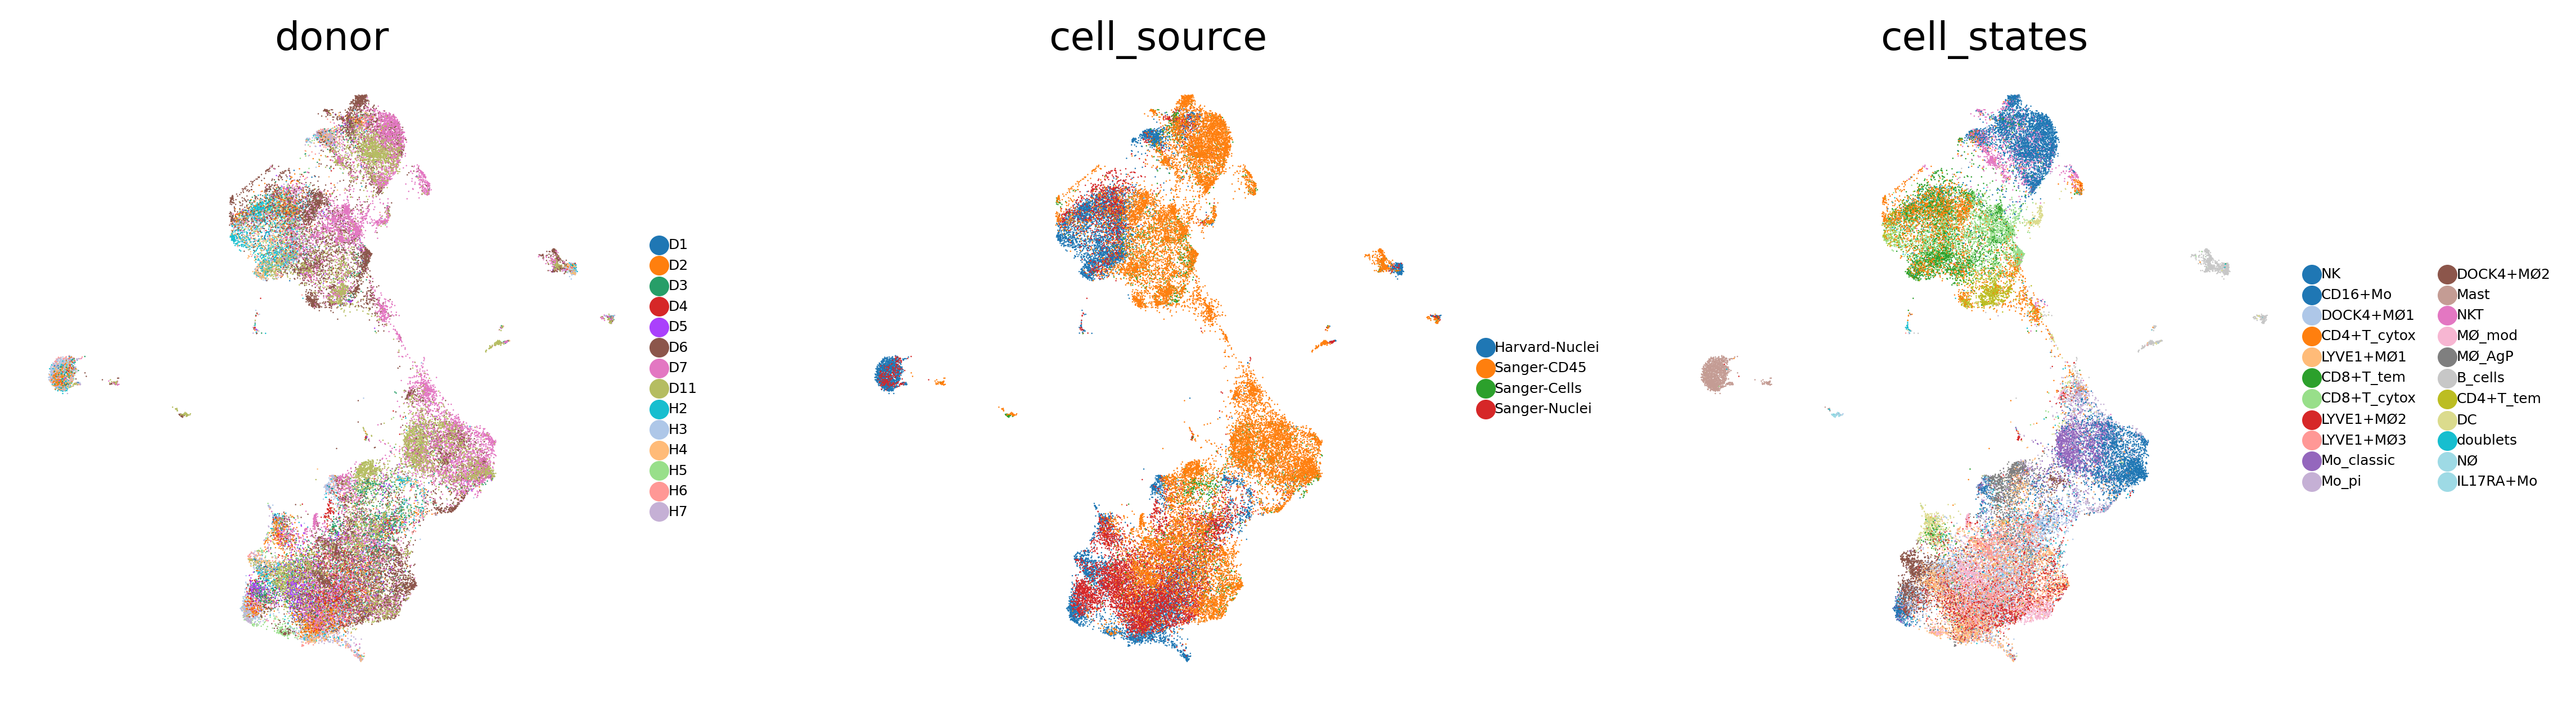

In [17]:
sc.pp.neighbors(heart_immune, use_rep = "X_scVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(heart_immune, min_dist = 0.1, spread = 3, random_state = 1712)
sc.pl.umap(heart_immune, frameon = False, color = ['donor', 'cell_source', 'cell_states'], size = 1, legend_fontsize = 5)

### Compare with original correction

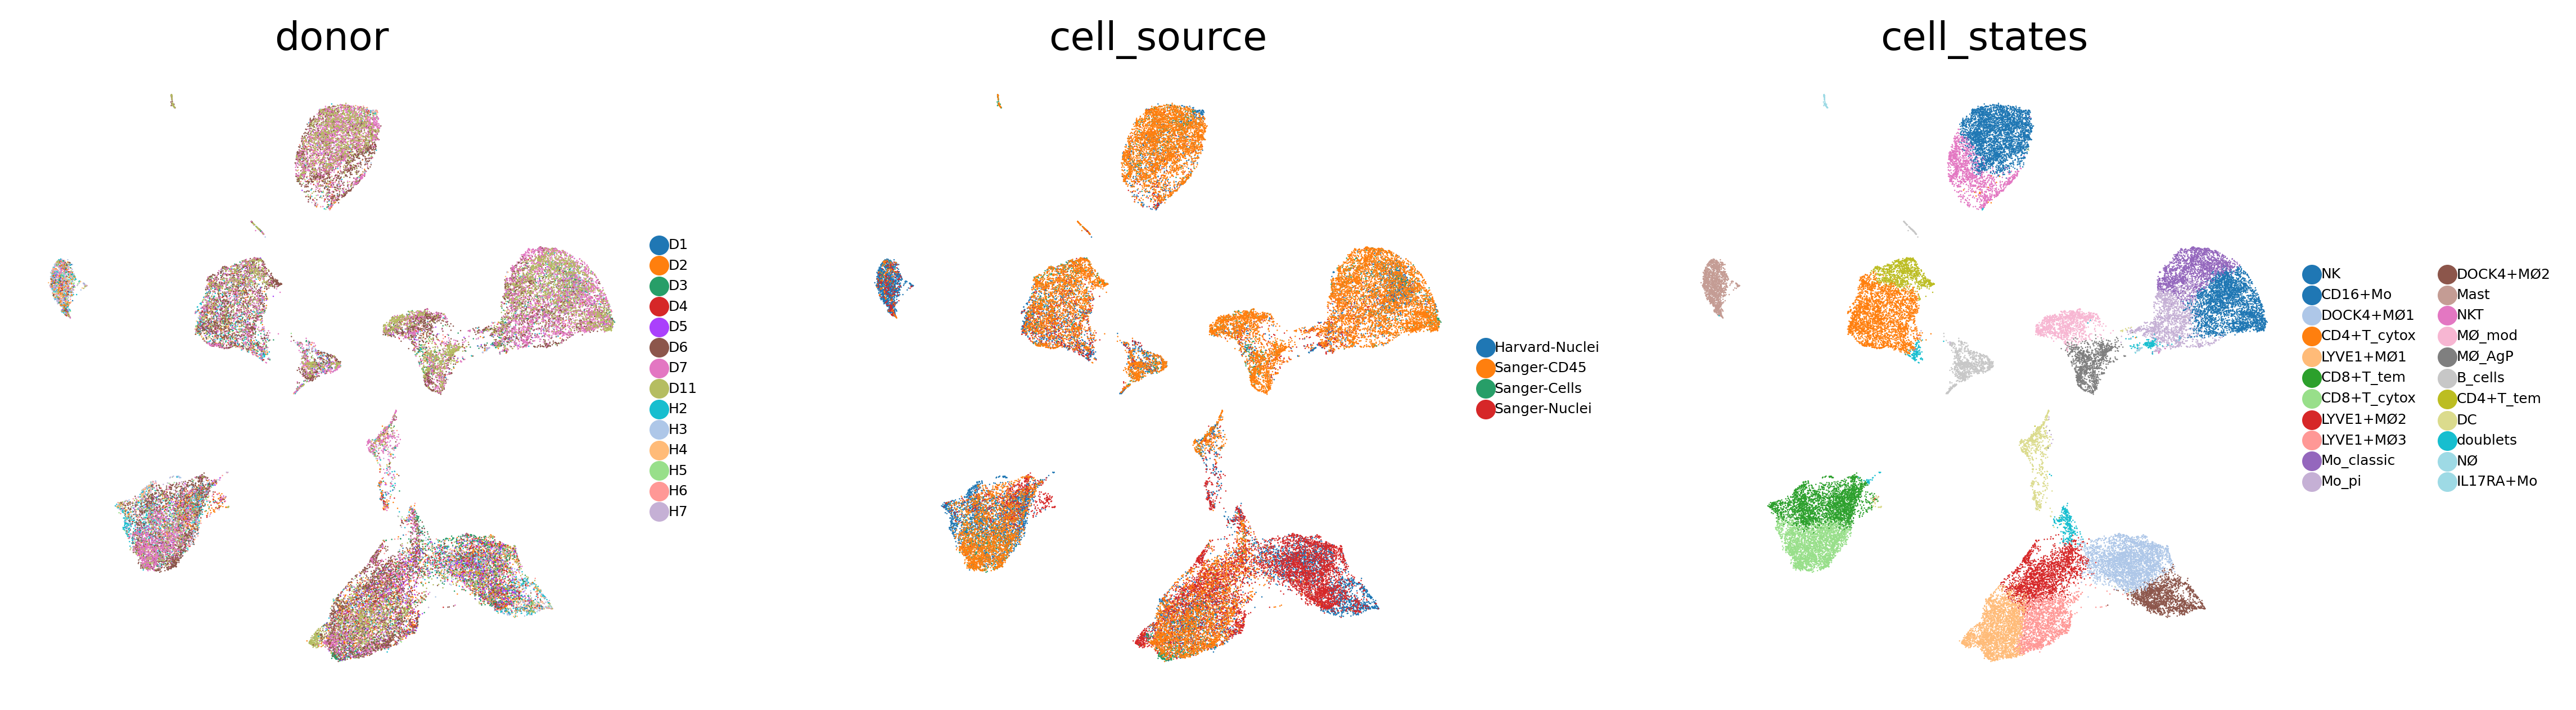

In [18]:
sc.pl.umap(adata_raw, frameon = False, color = ['donor', 'cell_source', 'cell_states'], size = 1, legend_fontsize = 5)